In [52]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import itertools
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [53]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [54]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [55]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results, adf_test, kpss_test

# Setup

## variables

In [56]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [57]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr_diff'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr2_diff'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr2_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_train', train0_df['FEDFUNDS_diff'], np.zeros(train0_df.shape[0]), train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS_diff'], np.zeros(test0_df.shape[0]), test0_df.shape[0],1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (197, 22)
test_df:  (49, 22)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,0.0328,0.0279,0.9061,0.9519
1,ffef_tr_test,-13.6332,-13.9446,2.2484,1.4995
2,ffef_tr2_train,-0.3337,-0.3406,1.2494,1.1178
3,ffef_tr2_test,0.5059,0.4954,0.0759,0.2755
4,Naive_train,-0.0001,-0.0001,0.9369,0.9680
5,Naive_test,-0.0633,-0.0633,0.1634,0.4042


# Load Data

In [58]:
def log_transform(x):
    print(x)
    return np.log(x + 1)

# tsa.SARIMAX

In [59]:
taylor_df = load_taylor()
taylor_df = taylor_df.query('DATE >= "1990-01-01"')
taylor_df['FEDFUNDS_log'] = np.log(taylor_df['FEDFUNDS'])

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)


In [60]:
train_df, test_df = time_split(taylor_df)

train_df:  (107, 23)
test_df:  (27, 23)


In [61]:
#case = 1  # Full Model
#case = 2  # Modified Taylor Rule
#case = 3  # Recession Model
#case = 4  # Simple Model
#case = 5  # Recession Model
case = None  # Feature Selection

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    
    print('-- Full Model (Lasso Base)')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_test = test_df['FEDFUNDS_diff']

    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_gdp','gap_ue']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')

    
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 2:
    
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
    
    
    
elif case == 3:
    print('-- Recession Model')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1','Real_Interest_Rate']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

elif case == 4:
    print('-- Simplified Model')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )

    
elif case == 5:
    print('-- Recession Model (minus Real Interest Rates)')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 6:
    print('-- Feature Selection')
    X_train = train_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

    
    
else:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )    


-- All Variables


In [62]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)


#X_train_const = sm.add_constant(X_train_trf)

In [63]:
# Define ranges for p, d, q, P, D, Q, and seasonal period
p_values = range(0, 3)  # Range for p (AR parameter)
d_values = range(0, 2)  # Range for d (Differencing parameter)
q_values = range(0, 3)  # Range for q (MA parameter)
P_values = range(0, 3)  # Range for seasonal P parameter
D_values = range(0, 2)  # Range for seasonal D parameter
Q_values = range(0, 3)  # Range for seasonal Q parameter
s_values = [4]  # Seasonal period (e.g., 12 for monthly data)

best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Iterate over different orders to find the best model
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            seasonal_order = (P, D, Q, s)
                            order = (p, d, q)
                            try:
                                #$model = sm.tsa.SARIMAX(ts_data, order=order, seasonal_order=seasonal_order)
                                print('order:' , order , ' seasonal_order: ' ,seasonal_order)
                                model = sm.tsa.SARIMAX(y_train, order=order, seasonal_order=seasonal_order , enforce_stationarity=True, exog=X_train_trf)
                                results = model.fit(disp=False)
                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except:
                                continue

# Print the best orders found
print("Best AIC:", best_aic)
print("Best Order (p, d, q):", best_order)
print("Best Seasonal Order (P, D, Q, s):", best_seasonal_order)

order: (0, 0, 0)  seasonal_order:  (0, 0, 0, 4)
order: (0, 0, 0)  seasonal_order:  (0, 0, 1, 4)
order: (0, 0, 0)  seasonal_order:  (0, 0, 2, 4)
order: (0, 0, 0)  seasonal_order:  (0, 1, 0, 4)
order: (0, 0, 0)  seasonal_order:  (0, 1, 1, 4)
order: (0, 0, 0)  seasonal_order:  (0, 1, 2, 4)
order: (0, 0, 0)  seasonal_order:  (1, 0, 0, 4)
order: (0, 0, 0)  seasonal_order:  (1, 0, 1, 4)
order: (0, 0, 0)  seasonal_order:  (1, 0, 2, 4)
order: (0, 0, 0)  seasonal_order:  (1, 1, 0, 4)
order: (0, 0, 0)  seasonal_order:  (1, 1, 1, 4)
order: (0, 0, 0)  seasonal_order:  (1, 1, 2, 4)
order: (0, 0, 0)  seasonal_order:  (2, 0, 0, 4)
order: (0, 0, 0)  seasonal_order:  (2, 0, 1, 4)
order: (0, 0, 0)  seasonal_order:  (2, 0, 2, 4)
order: (0, 0, 0)  seasonal_order:  (2, 1, 0, 4)
order: (0, 0, 0)  seasonal_order:  (2, 1, 1, 4)
order: (0, 0, 0)  seasonal_order:  (2, 1, 2, 4)
order: (0, 0, 1)  seasonal_order:  (0, 0, 0, 4)
order: (0, 0, 1)  seasonal_order:  (0, 0, 1, 4)
order: (0, 0, 1)  seasonal_order:  (0, 0

In [78]:
#model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)
#model = sm.tsa.SARIMAX(y_train, order=(2,1,2), seasonal_order=(0, 0, 0, 4), enforce_stationarity=True, exog=X_train_trf)
#model = sm.tsa.SARIMAX(y_train, order=(1,1,0), seasonal_order=(1, 1, 2, 4), enforce_stationarity=True, exog=X_train_trf)
model = sm.tsa.SARIMAX(y_train, order=(1,0,0), seasonal_order=(0, 0, 0, 4),enforce_stationarity=True, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          FEDFUNDS_diff   No. Observations:                  107
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -15.954
Date:                Mon, 27 Nov 2023   AIC                             51.908
Time:                        22:11:05   BIC                             78.636
Sample:                    03-31-1990   HQIC                            62.743
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__gap_inf                                0.0458      0.027      1.728      0.084      -0.006       0.098
num__gap_gdp                                0.4447      0.203      2.192      0.028       0.047       0.842
num__gap_ue                                -0.0382      0.087     -0.438      0.661      -0.209       0.133
num__Real_Interest_Rate                     0.3259      0.324      1.006      0.315      -0.309       0.961
num__CPIAUCSL_PC1                           0.0458      0.027      1.728      0.084      -0.006       0.098
num__UNRATE                                 0.0376      0.087      0.431      0.666      -0.133       0.209
num__FEDFUNDS-1                            -0.9419      0.362     -2.603      0.009      -1.651      -0.233
cat__onehotencoder__recession_flag_True    -0.1770      0.094     -1.883      0.060      -0.361       0.007
ar.L1                                       0.6621      0.101      6.567      0.000       0.464       0.860
sigma2                                      0.0785      0.010      7.907      0.000       0.059       0.098
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                32.85
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.84
Prob(H) (two-sided):                  0.75   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.69e+19. Standard errors may be unstable.
"""

In [65]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [66]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS_diff,mean,mean_se,mean_ci_lower,mean_ci_upper
1990-03-31,-3.546574,1000.000052,-1963.510661,1956.417513
1990-06-30,-3.328864,1000.000151,-1963.293145,1956.635417
1990-09-30,-3.333192,1000.000284,-1963.297733,1956.631349
1990-12-31,-3.570319,1000.000431,-1963.535148,1956.394510
1991-03-31,-3.668393,1000.000574,-1963.633502,1956.296717
...,...,...,...,...
2015-09-30,1.729431,1000.011141,-1958.256390,1961.715252
2015-12-31,1.700401,1000.011249,-1958.285632,1961.686434
2016-03-31,1.808288,1000.011357,-1958.177956,1961.794532
2016-06-30,1.656394,1000.011465,-1958.330062,1961.642850


<Axes: xlabel='DATE'>

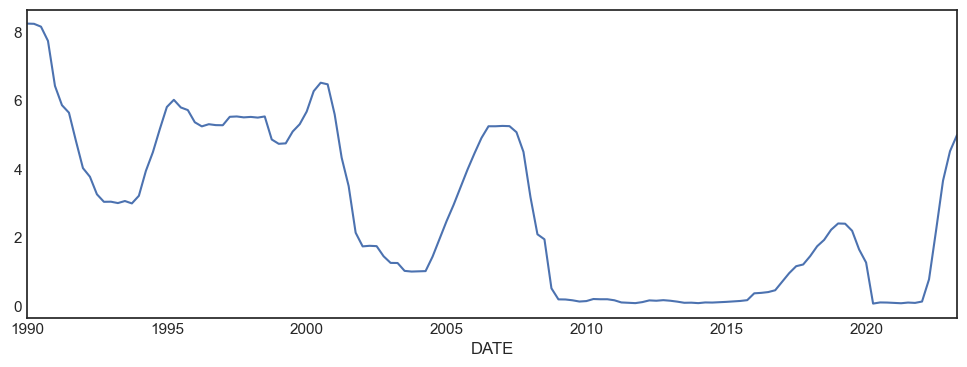

In [67]:
taylor_df["FEDFUNDS"].dropna().plot(figsize=(12, 4))

<Axes: xlabel='DATE'>

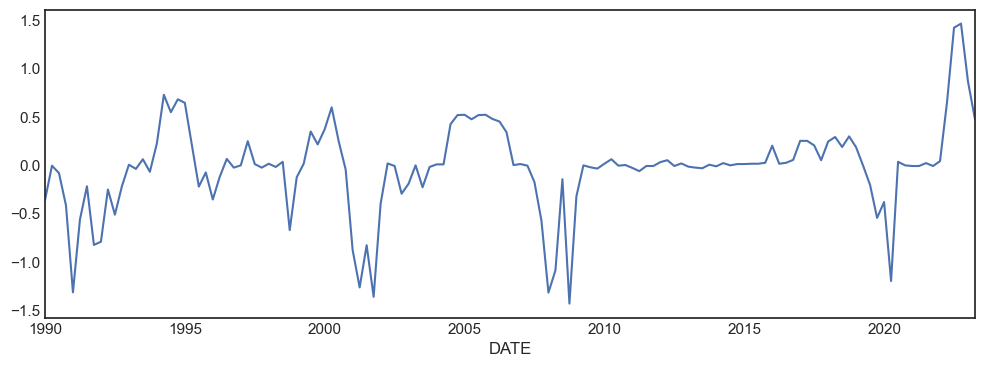

In [68]:
taylor_df["FEDFUNDS_diff"].dropna().plot(figsize=(12, 4))

<Axes: xlabel='DATE'>

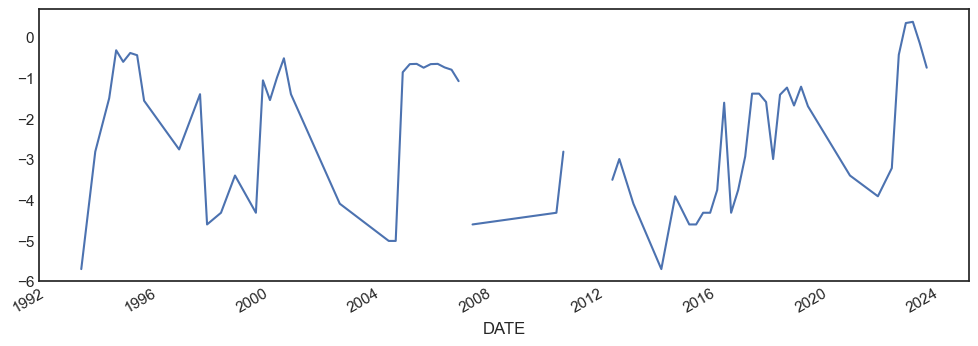

In [69]:
np.log(taylor_df["FEDFUNDS_diff"]).dropna().plot(figsize=(12, 4))

In [70]:
#p-value < 0.05 - stationary

# Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can 
# not be rejected. Hence, the series is non-stationary.

adf_test(taylor_df["FEDFUNDS_diff"])

Results of Dickey-Fuller Test:
Test Statistic                  -4.767329
p-value                          0.000063
#Lags Used                       0.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


In [71]:
#p-value > 0.05 - stationary

# Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting 
# the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test

kpss_test(taylor_df["FEDFUNDS_diff"])

Results of KPSS Test:
Test Statistic           0.213981
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


## Test

In [72]:
X_test_trf = t_fit.transform(X_test)
X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = test_df.index
X_test_trf.set_index('DATE', inplace=True)


y_test = test_df['FEDFUNDS']

In [73]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [74]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(27, 4)

In [75]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

,lower FEDFUNDS_diff,upper FEDFUNDS_diff
2016-12-31,-0.136307,0.242373
2017-03-31,-0.213964,0.422262
2017-06-30,-0.538681,0.362657
2017-09-30,-0.840665,0.312440
2017-12-31,-0.972189,0.398900


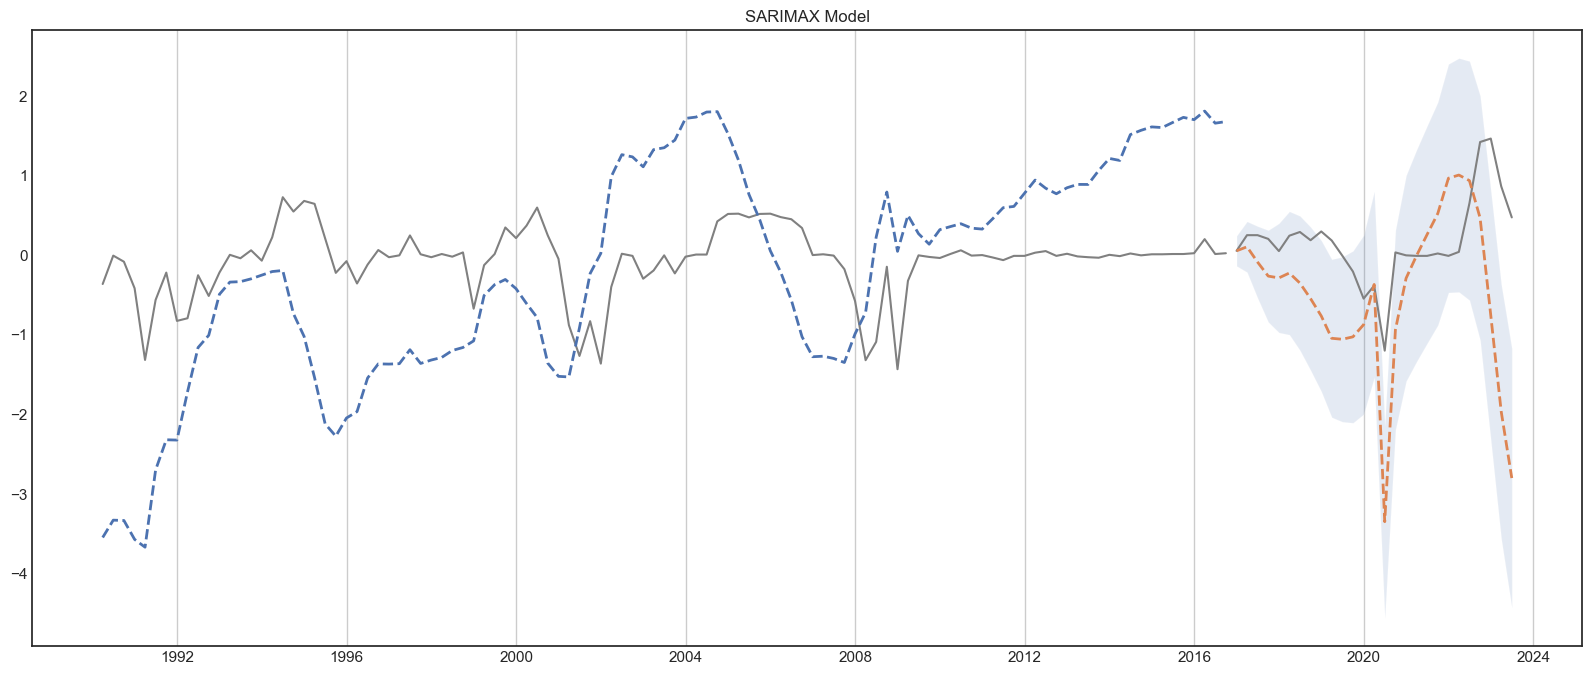

In [76]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS_diff'], predict_ci['upper FEDFUNDS_diff'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [77]:
model_stats_df = model_results('SARIMAX_train',train_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )
model_stats_df = model_results('SARIMAX_test', test_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,0.0328,0.0279,0.9061,0.9519
1,ffef_tr_test,-13.6332,-13.9446,2.2484,1.4995
2,ffef_tr2_train,-0.3337,-0.3406,1.2494,1.1178
3,ffef_tr2_test,0.5059,0.4954,0.0759,0.2755
4,Naive_train,-0.0001,-0.0001,0.9369,0.9680
5,Naive_test,-0.0633,-0.0633,0.1634,0.4042
6,SARIMAX_train,-3.1408,-3.4336,24.6724,4.9671
7,SARIMAX_test,-3.3975,-5.0176,7.8127,2.7951
